In [56]:
from keras.layers import Input, Dense, Activation, TimeDistributed, Softmax, TextVectorization, Reshape, RepeatVector, GRU, Conv1D, Bidirectional, AveragePooling1D, UpSampling1D, Embedding, Concatenate, GlobalAveragePooling1D, LSTM, Multiply
from keras.models import Model
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

DATA_DIR = pathlib.Path.cwd().parent / 'data'
N_classes = 150
dataframe = pd.read_csv(DATA_DIR / 'processed_data.csv')

In [57]:
df = dataframe.copy()

df['Tag'] = df['Tag'].apply(lambda x: literal_eval(x))
df['Tag'] = df['Tag'].apply(lambda x : x[0]) # Getting the most important tag from the 
df['Tag'] = df['Tag'].apply(lambda x : str(x))
baseline_df = df.loc[:,['Body','Tag']].sample(frac=0.5)
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549322 entries, 1016787 to 1044696
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Body    549322 non-null  object
 1   Tag     549322 non-null  object
dtypes: object(2)
memory usage: 12.6+ MB


In [58]:
baseline_df.reset_index(inplace=True)

In [83]:
unicos = baseline_df['Tag'].unique()
unicos

array(['c++', 'mysql', 'html', 'sql-server-2008', 'selenium', 'python',
       'java', 'android', 'matlab', 'php', 'ruby-on-rails', 'javascript',
       'ios', 'jquery', 'iphone', 'xml', '.net', 'oracle', 'c#',
       'amazon-web-services', 'ruby', 'regex', 'r', 'sql-server',
       'node.js', 'asp.net', 'scala', 'powershell', 'image',
       'objective-c', 'css', 'jsp', 'sql', 'maven', 'excel', 'hadoop',
       'actionscript-3', 'bash', 'haskell', 'angularjs', 'c', 'vb.net',
       'eclipse', 'algorithm', 'asp.net-mvc', 'windows', 'perl', 'email',
       'django', 'python-2.7', 'delphi', 'linq', 'security',
       'internet-explorer', 'excel-vba', 'tsql', 'mongodb', 'flash',
       'hibernate', 'wpf', 'list', 'object', 'arrays', 'http',
       'wordpress', 'user-interface', 'python-3.x', 'laravel',
       'cocoa-touch', '.htaccess', 'css3', 'facebook', 'spring', 'string',
       'git', 'ajax', 'batch-file', 'osx', 'postgresql', 'jquery-ui',
       'web-services', 'wcf', 'linux', 'apac

In [60]:
DATASET_DIR = 'dataset/'
if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
    os.mkdir(DATASET_DIR + "/train")
    for i in unicos:
        os.mkdir(DATASET_DIR + "/train/" + i)
    os.mkdir(DATASET_DIR + "/test")
    for i in unicos:
        os.mkdir(DATASET_DIR + "/test/" + i)
    

In [61]:
reviews = baseline_df['Body']
labels = baseline_df['Tag']
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, train_size=0.8)

n_texto = 0
for i in tqdm(range(len(y_train))):
    texto = x_train.iloc[i]
    fname = 'body_' + str(n_texto) + '.txt'
    with open(DATASET_DIR + "train/" + y_train.iloc[i] + "/" + fname, 'w') as f:
        f.write(texto)
        n_texto += 1

for i in tqdm(range(len(y_test))):
    texto = x_test.iloc[i]
    fname = 'tag_' + str(n_texto) + '.txt'
    with open(DATASET_DIR + "/test/" + y_test.iloc[i] + "/" + fname, 'w') as f:
        f.write(texto)
        n_texto += 1

print("Criei textos:", n_texto)

100%|██████████| 109865/109865 [00:06<00:00, 16279.47it/s]

Criei textos: 549322


In [62]:
from tensorflow.keras.utils import text_dataset_from_directory

dataset_train = text_dataset_from_directory(
    DATASET_DIR + '/train',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=1024,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

dataset_test = text_dataset_from_directory(
    DATASET_DIR+ '/test',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=1024,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 439457 files belonging to 150 classes.
Found 109865 files belonging to 150 classes.


In [63]:
vocab_size = 10000
vectorize_layer = TextVectorization(max_tokens = vocab_size,output_sequence_length=256)
vectorize_layer.adapt(dataset_train.map(lambda x,label:x))

2023-06-07 16:22:24.830040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [439457]
	 [[{{node Placeholder/_4}}]]
2023-06-07 16:22:24.830314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [439457]
	 [[{{node Placeholder/_4}}]]


In [66]:
def convolve_and_downsample(input_n_samples, input_embedding_size, n_filters, kernel_size=3, **kwargs):
    input_layer = Input(shape=(input_n_samples,input_embedding_size))
    x = input_layer
    x = Conv1D( filters=n_filters,
                kernel_size=kernel_size,
                padding='same',
                use_bias=False,
                )(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Activation('elu')(x)
    return Model(input_layer, x, **kwargs)

def deep_cnn_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size, number_of_ngrams=16, n_gram_size=3):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x_ = Reshape( (-1,))(x)
    x = Dense(N_classes, name='classificador')(x_)
    x = Activation('softmax')(x)
    return Model(input_layer, x), Model(input_layer, x_)
clf_classifier,clf_extractor = deep_cnn_embedding_softmax_model(vectorize_layer)
print(clf_classifier.summary())
print(clf_extractor.summary())
clf_classifier.compile(loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 256)              0         
 ectorization)                                                   
                                                                 
 projecao (Embedding)        (None, 256, 2)            20000     
                                                                 
 ngramas (Functional)        (None, 128, 16)           96        
                                                                 
 reshape_3 (Reshape)         (None, 2048)              0         
                                                                 
 classificador (Dense)       (None, 150)               307350    
                                                          

In [67]:
history = clf_classifier.fit(dataset_train, epochs=10, verbose=1, validation_data=dataset_test)


Epoch 1/10
429/430 [============================>.] - ETA: 0s - loss: 3.4965 - accuracy: 0.1484

2023-06-07 16:23:39.185791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [109865]
	 [[{{node Placeholder/_0}}]]
2023-06-07 16:23:39.186130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [109865]
	 [[{{node Placeholder/_0}}]]


430/430 [==============================] - 32s 73ms/step - loss: 3.4963 - accuracy: 0.1485 - val_loss: 3.0931 - val_accuracy: 0.2247
Epoch 2/10
430/430 [==============================] - 31s 72ms/step - loss: 2.9053 - accuracy: 0.2819 - val_loss: 2.7803 - val_accuracy: 0.3222
Epoch 3/10
430/430 [==============================] - 30s 70ms/step - loss: 2.6929 - accuracy: 0.3568 - val_loss: 2.6546 - val_accuracy: 0.3787
Epoch 4/10
430/430 [==============================] - 30s 70ms/step - loss: 2.5870 - accuracy: 0.3914 - val_loss: 2.5931 - val_accuracy: 0.3891
Epoch 5/10
430/430 [==============================] - 30s 70ms/step - loss: 2.5119 - accuracy: 0.4133 - val_loss: 2.5229 - val_accuracy: 0.4235
Epoch 6/10
430/430 [==============================] - 30s 70ms/step - loss: 2.4406 - accuracy: 0.4347 - val_loss: 2.4640 - val_accuracy: 0.4386
Epoch 7/10
430/430 [==============================] - 30s 70ms/step - loss: 2.3785 - accuracy: 0.4530 - val_loss: 2.4148 - val_accuracy: 0.4592
Epo

In [68]:
clf_classifier.evaluate(dataset_test)

108/108 [==============================] - 4s 39ms/step - loss: 2.3058 - accuracy: 0.4809


[2.305760383605957, 0.48088109493255615]

In [75]:
a = clf_classifier.predict(["""31

I was looking for a tutorial on how to install Python libraries in the wheel format.

It does not seem straightforward so I'd appreciate a simple step by step tutorial how to install the module named "requests" for CPython.

I downloaded it from: https://pypi.python.org/pypi/requests and now I have a .whl file. I've got Python 2.7 and 3.3 on Windows, so how do I install it so all the other Python scripts I run can use it?"""])



1/1 [==============================] - 0s 35ms/step


In [88]:
dataset_train.class_names

['.htaccess',
 '.net',
 'actionscript-3',
 'ajax',
 'algorithm',
 'amazon-web-services',
 'android',
 'android-layout',
 'android-studio',
 'angularjs',
 'apache',
 'api',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'asp.net-mvc-3',
 'asp.net-mvc-4',
 'azure',
 'bash',
 'batch-file',
 'c',
 'c#',
 'c++',
 'c++11',
 'class',
 'cocoa',
 'cocoa-touch',
 'codeigniter',
 'cordova',
 'css',
 'css3',
 'csv',
 'database',
 'date',
 'datetime',
 'debugging',
 'delphi',
 'django',
 'eclipse',
 'email',
 'entity-framework',
 'excel',
 'excel-vba',
 'facebook',
 'file',
 'flash',
 'forms',
 'function',
 'git',
 'google-app-engine',
 'google-chrome',
 'google-maps',
 'hadoop',
 'haskell',
 'hibernate',
 'html',
 'html5',
 'http',
 'image',
 'internet-explorer',
 'ios',
 'ipad',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'jquery-ui',
 'jsf',
 'json',
 'jsp',
 'laravel',
 'linq',
 'linux',
 'list',
 'listview',
 'loops',
 'magento',
 'matlab',
 'maven',
 'mongodb',
 'ms-access',
 'multithreading',
 '

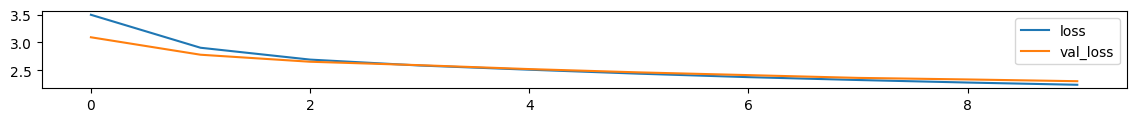

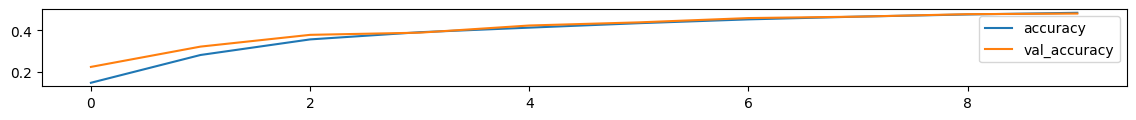

In [92]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [91]:
# Acabei por nao ter treinado o modelo diversas vezes por conta de tempo
clf_classifier.save("inhouse")

2023-06-07 16:51:24.253585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_21' with dtype string and shape [?,1]
	 [[{{node input_21}}]]
2023-06-07 16:51:24.288877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_21' with dtype string and shape [?,1]
	 [[{{node input_21}}]]
2023-06-07 16:51:24.297015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128,16]
	 [[{{node inputs}}]]
2023-06

INFO:tensorflow:Assets written to: inhouse/assets


2023-06-07 16:51:24.750845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input_21' with dtype string and shape [?,1]
	 [[{{node serving_default_input_21}}]]
INFO:tensorflow:Assets written to: inhouse/assets
